<a href="https://colab.research.google.com/github/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Modeling
With our cleaned data in hand, we now want to train some models on our data set. In particular, we want to see how well they can predict drug category based on the processed reports. Precision will be our metric, as we want a model that is able to reproduce similar reports itself.

### Step 1: Importing Libraries
This section is about loading all the necessary libraries to conduct the project.

General Libraries like itertools and re for general programming tasks.
Natural Language Processing Libraries such as nltk and gensim for text processing and modeling.
Machine Learning Libraries like sklearn, tensorflow, xgboost for building, training, and evaluating models.
Data Handling Libraries like numpy, pandas for managing and manipulating data.
Visualization Libraries such as matplotlib, seaborn for creating plots.
Imbalanced Learning Library imblearn to handle imbalanced datasets.
Word Cloud Library wordcloud for visualizing word frequency.

In [51]:
!pip install numpy --upgrade
!pip install lime

import itertools
import re
from ast import literal_eval

import pickle
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import random
import joblib
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from wordcloud import WordCloud
from xgboost import XGBClassifier
from lime.lime_text import LimeTextExplainer
from random import randint

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 2: Data Loading and Preprocessing
This part loads the dataset and provides information about its structure


In [52]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67875 entries, 0 to 67874
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   drug              67875 non-null  object
 1   dosage            66103 non-null  object
 2   delivery          65447 non-null  object
 3   weight            67875 non-null  int64 
 4   gender            67875 non-null  object
 5   report            67875 non-null  object
 6   processed_report  67875 non-null  object
 7   mixed             67875 non-null  int64 
 8   drug_category     67875 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.7+ MB


In [53]:
df.head()

,drug,dosage,delivery,weight,gender,report,processed_report,mixed,drug_category
0,mdpv,NaN,insufflated,140,male,"MDPV, Over a Two-Month PeriodI thought I'd sha...","[['mdpv', '', 'over', 'a', 'twomonth', 'period...",1,Entactogen/Empathogen
1,crack,repeated,smoked,165,male,I'll start this story with a bit of background...,"[['i', 'll', 'start', 'this', 'story', 'with',...",0,Stimulant
2,methcathinone,10 mg,IV,135,male,I hate the name of this drug. Impossible for m...,"[['i', 'hate', 'the', 'name', 'of', 'this', 'd...",1,Stimulant
3,jwh-018,,smoked,209,male,"Me - Male (95kg, 29 y/o, moderate experience o...","[['me', '', 'male', '', '95kg', '', '29', 'yo'...",1,Cannabinoid
4,pharms - pregabalin,,,170,male,GBL AddictI was thinking of writing this for a...,"[['gbl', 'addicti', 'wa', 'thinking', 'of', 'w...",1,Pharmaceutical


Looks like our data was imported cleanly and has been randomized.

## Data Preperation for Models
Our goal is to train at least three models and that compare which achives the highest precision. Our three models are a logistic regression, a random forest classifier, and an XGBoost model.

We are going to start by creating a Word2Vec model to use in our more complex multiclassifcation problems. Imagine the words in psychedelic trip reports are like ingredients in a complex recipe. Word2Vec helps translate these words into a language that a computer, such as a Random Forest Classifier (RFC), understands. It’s like having a taste expert who knows the flavor of each ingredient (Word2Vec) working with a skilled chef (RFC) to create a dish. Together, they recognize unique flavors and combinations in trip reports, allowing us to identify specific experiences or drug categories more accurately.

In [ ]:
# Convert string representations of lists into actual lists
df['processed_report'] = df['processed_report'].apply(literal_eval)

# Now flatten the lists
df['processed_report'] = df['processed_report'].apply(lambda x: [word for sublist in x for word in sublist])

# Verify the conversion
print(type(df['processed_report'].iloc[0]))


In [54]:
# Function to convert a report into a vector
def report_to_vector(report, model):
    report_vec = []
    numw = 0
    for word in report:
        try:
            if numw == 0:
                report_vec = model.wv[word]
            else:
                report_vec = np.add(report_vec, model.wv[word])
            numw+=1
        except:
            pass
    return np.asarray(report_vec) / numw if numw != 0 else np.zeros(model.vector_size)

In [55]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([report_to_vector(report, self.model) for report in X])

In [36]:
tokenized_reports = df['processed_report'].tolist()

# Train a Word2Vec model
word2vec = Word2Vec(sentences=tokenized_reports, vector_size=100, window=5, min_count=5, workers=4)

#Save the model
#word2vec.save("D:/Cloud/Google Drive/Colab Notebooks/Data/word2vec_model.model")

NameError: ignored

The next step sets our dependent and independent variables for our models. Additionally, the target variable (drug_category) is encoded to numerical form.

In [56]:
# Define y
y = df['drug_category']

# Encode the labels in y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X = df['processed_report']

## Defining Pipelines
We'll define three pipelines, starting with a Logistic Regression as a baseline, and then Random Forest, and XGBoost to see if we can get imrpovements. Because of our class imbalance, we will include SMOTE for each. While the logistic Regression will use TF-IDF, while Random Forest and XGBoost will later use the Word2Vec we created earlier.

* **TF-IDF**: Helps transform text into a numerical format the model can understand.
* **SMOTE**: Handles class imbalance.

In [57]:
def to_string_func(x):
    return [' '.join(i) if isinstance(i, list) else i for i in x]

# Define pipeline for Logistic Regression with TF-IDF
pipeline_lr = ImbPipeline([
    ('to_string', FunctionTransformer(to_string_func)),
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('clf', LogisticRegression(max_iter=500, C=1.0, solver='saga', n_jobs=-1))
])

# Define pipeline for RFC and XGB (SMOTE included; Word2Vec will be applied later)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1))
])

pipeline_xgb = ImbPipeline([
    ('smote', SMOTE()),
    ('clf', XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, eval_metric='mlogloss'))
])

## Data Splitting and Stratification
Next we'll split and stratify the data for the Logistic Regression model. For the Random Forest and XGBoost models, we'll load the Word2Vec-transformed data and stratify that.

In [58]:
# Split and stratify data for Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Load Word2Vec Model and transformed reports for RFC and XGB
word2vec_model = Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/Data/word2vec_model.model")
transformed_reports = '/content/drive/MyDrive/Colab Notebooks/Data/transformed_reports.pkl'

with open(transformed_reports, "rb") as f:
    X_word2vec = pickle.load(f)

X_word2vec = np.vstack(X_word2vec)

# Split and stratify data for RFC and XGB
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(X_word2vec, y_encoded))
X_train_w2v, X_test_w2v = X_word2vec[train_index], X_word2vec[test_index]
y_train_w2v, y_test_w2v = y_encoded[train_index], y_encoded[test_index]

## Training, Prediction, and Comparison
Here, we'll train the models, make predictions, and compare the results. This can be done by creating functions train_and_predict and compare_results.

In [59]:
def train_and_predict(pipeline, X_train, y_train, X_test):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the train and test set
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    return y_train_pred, y_test_pred

def compare_results(model_name, y_train, y_train_pred, y_test, y_test_pred):
    print(f"\n{model_name} - Train Classification Report:")
    print(classification_report(y_train, y_train_pred, zero_division=1))
    print(f"{model_name} - Test Classification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=1))


In [9]:
# Train and Predict for Logistic Regression (LR)
y_train_pred_lr, y_test_pred_lr = train_and_predict(pipeline_lr, X_train_lr, y_train_lr, X_test_lr)
compare_results("Logistic Regression", y_train_lr, y_train_pred_lr, y_test_lr, y_test_pred_lr)

# Train and Predict for Random Forest (RFC)
y_train_pred_rf, y_test_pred_rf = train_and_predict(pipeline_rf, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("Random Forest", y_train_w2v, y_train_pred_rf, y_test_w2v, y_test_pred_rf)

# Train and Predict for XGBoost (XGB)
y_train_pred_xgb, y_test_pred_xgb = train_and_predict(pipeline_xgb, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("XGBoost", y_train_w2v, y_train_pred_xgb, y_test_w2v, y_test_pred_xgb)


Logistic Regression - Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.56      4622
           1       0.55      0.65      0.59      1809
           2       0.68      0.88      0.76      2116
           3       0.78      0.86      0.82      5166
           4       0.75      0.91      0.82      2814
           5       0.75      0.88      0.81      1967
           6       0.83      0.75      0.78      4999
           7       0.81      0.77      0.79      5231
           8       0.89      0.85      0.87     22690
           9       0.74      0.74      0.74      2886

    accuracy                           0.80     54300
   macro avg       0.74      0.78      0.75     54300
weighted avg       0.80      0.80      0.80     54300

Logistic Regression - Test Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.39      0.41      1155
           1       0.32      0

In [62]:
# Train and Predict for Random Forest (RFC)
y_train_pred_rf, y_test_pred_rf = train_and_predict(pipeline_rf, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("Random Forest", y_train_w2v, y_train_pred_rf, y_test_w2v, y_test_pred_rf)


Random Forest - Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      4622
           1       0.67      0.74      0.70      1809
           2       0.80      0.86      0.83      2116
           3       0.83      0.90      0.86      5166
           4       0.83      0.91      0.87      2814
           5       0.85      0.88      0.87      1967
           6       0.88      0.87      0.87      4999
           7       0.86      0.85      0.85      5231
           8       0.93      0.89      0.91     22690
           9       0.81      0.83      0.82      2886

    accuracy                           0.86     54300
   macro avg       0.82      0.84      0.83     54300
weighted avg       0.86      0.86      0.86     54300

Random Forest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32      1155
           1       0.25      0.26      0.2

The categories we are most interested in are 3 (empathogen/entactogen), 4 (entheogen), and 8 (Psychedelics).

And since we were targeting precision, it looks like our logestic regression performed best on the test set and our RFC performed best on the training set, which indicates overfitting. Let's see if we can improve our RFC model with some parameter tuning. We will use GridSearch CV to find the best parameters and then train and test our model with those:

In [ ]:
# Define the parameter grid
param_grid = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5)

print("\nTraining Random Forest with hyperparameter tuning...")
# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

# Predict on the train and test set using the best model
y_train_pred_grid = grid_search.predict(X_train)
y_test_pred_grid = grid_search.predict(X_test)


Training Random Forest...


In [ ]:
# Generate and print the classification report for both train and test
print("Train Classification Report (with tuning):")
print(classification_report(y_train, y_train_pred_grid, zero_division=1))
print("Test Classification Report (with tuning):")
print(classification_report(y_test, y_test_pred_grid, zero_division=1))

Train Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      3667
           1       0.71      0.79      0.75      1447
           2       0.82      0.89      0.85      1690
           3       0.85      0.90      0.87      4122
           4       0.86      0.93      0.89      2238
           5       0.87      0.89      0.88      1562
           6       0.88      0.89      0.89      3943
           7       0.88      0.87      0.87      4185
           8       0.94      0.90      0.92     18057
           9       0.82      0.85      0.84      2298

    accuracy                           0.88     43209
   macro avg       0.84      0.87      0.85     43209
weighted avg       0.88      0.88      0.88     43209

Test Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.29      0.31       917
           1       0.26      0.23      0.24       362
           2       0.

Comparing the untuned results to the tuned results shows us that while the tuned results did better on the training data: Entactogen/Empathogen (84/85), Entheogen (83/86), Psychedelic (93/94), they ended up doing worse on our test set (68/61), (63/55), (79/78). So we will stick with our original model to explore the results.

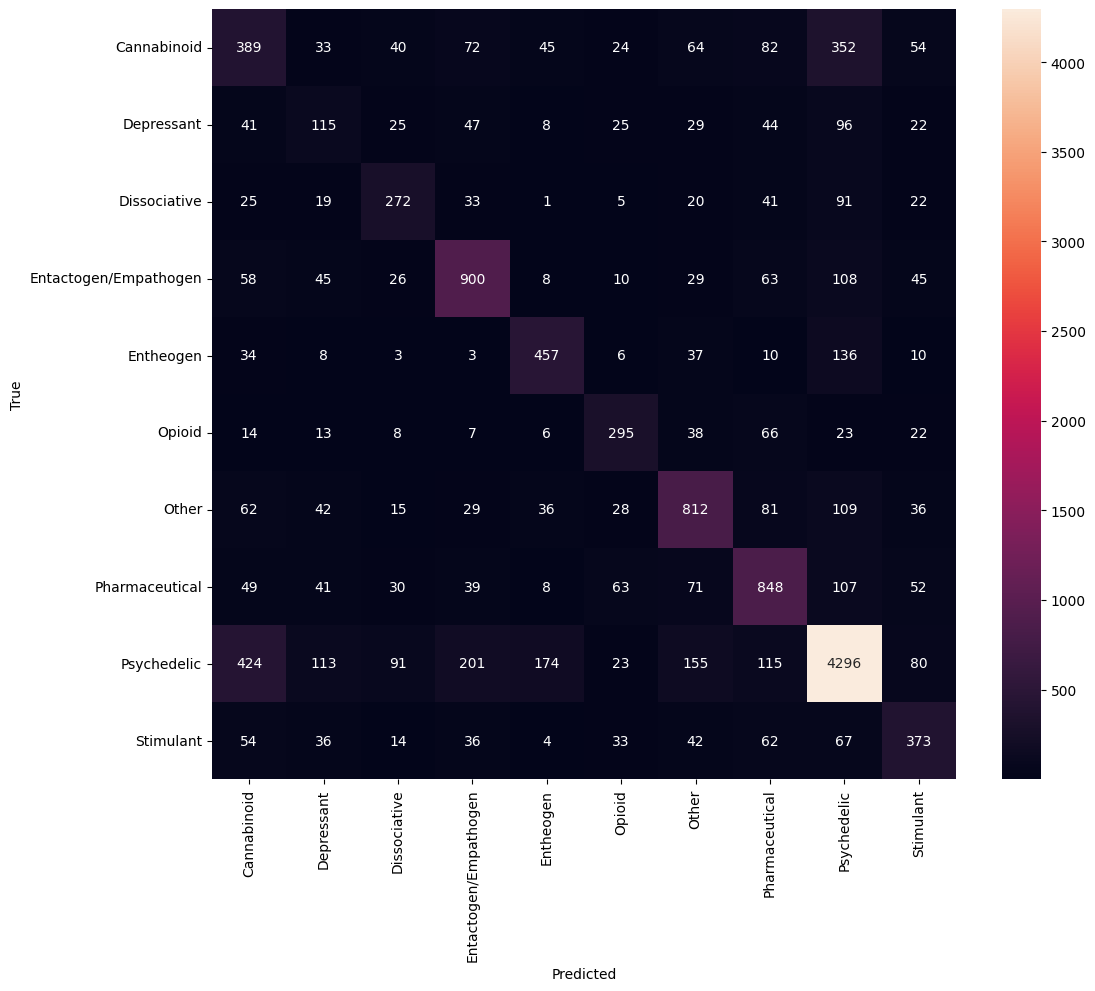

In [17]:
# Label the categories
encoder = LabelEncoder()
encoder.fit(df['drug_category'])
drug_categories = encoder.classes_

# Generate confusion matrices for test
cm_test = confusion_matrix(y_test_w2v, y_test_pred_rf)

# Plot confusion matrix for test set
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, xticklabels=drug_categories, yticklabels=drug_categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It looks like our model was most likely to label a psychedelic as a cannabinoid, entactogen/empathogen, or an entheogen, and least likely to label it a dissociative, opiod, or stimulat, which is what we would expect! Now let's check out some of the feature importances to see what it is our model thinks is valuable for making its predictions. We will use LIME. To do so, means we need to define a prediction probability function. This function should take a list of texts and return the predicted probabilities for each class for each text. It will use our Word2Vec model and our trained RFC pipeline.

In [44]:
print(pipeline_rf)

Pipeline(steps=[('smote', SMOTE()), ('clf', RandomForestClassifier(n_jobs=-1))])


In [60]:
# Load Word2Vec model
word2vec_model_path = "/content/drive/MyDrive/Colab Notebooks/Data/word2vec_model.model"
word2vec = Word2Vec.load(word2vec_model_path)

def preprocess_func(texts):
    transformed_texts = []
    for text in texts:
        # Convert the string representation of the list into an actual list
        processed_report = literal_eval(text)

        # Flatten the list
        processed_report = [word for sublist in processed_report for word in sublist]

        # Convert report into a vector
        report_vec = report_to_vector(processed_report, word2vec)

        transformed_texts.append(report_vec)

    return np.vstack(transformed_texts)

def predict_proba_func(texts):
    def report_to_vector_inner(report, model):
        report_vec = []
        numw = 0
        for word in report:
            try:
                if numw == 0:
                    report_vec = model.wv[word]
                else:
                    report_vec = np.add(report_vec, model.wv[word])
                numw += 1
            except:
                pass
        return np.asarray(report_vec) / numw if numw != 0 else np.zeros(model.vector_size)

    transformed_texts = preprocess_func(texts)
    return pipeline_rf.predict_proba(transformed_texts)


Next we create an explainer using LIME, then choose an instance to explain, and then have the model explain.

In [63]:
# Load the fitted model
pipeline_rf = joblib.load("/content/rf_model.joblib")

# Select a random index from the processed_report column
index_to_explain = randint(0, len(df['processed_report']) - 1)

# Get the processed report at the chosen index
instance = df['processed_report'].iloc[index_to_explain]

# Convert the processed report to a single string
instance_as_string = ' '.join(instance)

# Explain the prediction for the chosen instance
explainer = LimeTextExplainer(class_names=label_encoder.classes_)
explanation = explainer.explain_instance(instance_as_string, predict_proba_func)
explanation.show_in_notebook()

NotFittedError: ignored

In [ ]:
import pandas as pd

# Create a DataFrame to hold data
error_analysis_df = pd.DataFrame(X_test, columns=feature_names) # assuming feature_names contains your feature names
error_analysis_df['true'] = y_test
error_analysis_df['predicted'] = y_test_pred_rf

# Plot instances where prediction is correct vs incorrect
sns.scatterplot(x='feature1', y='feature2', hue='true', style=(error_analysis_df['true'] == error_analysis_df['predicted']), data=error_analysis_df)
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score

mcc = matthews_corrcoef(y_test, y_test_pred_rf)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred_rf)

print("Matthews correlation coefficient:", mcc)
print("Balanced accuracy score:", balanced_acc)
